In [1]:
path='C:\\Users\\Ben\\Desktop\\checkpoints\\'
h5_paths = []
for i in range(8):
    h5_paths.append(path + 'trial{}'.format(i) + '\\')

In [2]:
def vis_square(data, padsize=1, padval=0):

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    return data

In [30]:
from __future__ import print_function
import os
import sys
from collections import defaultdict

try:
    import cPickle as pickle
except ImportError:
    import pickle

from PIL import Image
from six.moves import range
import matplotlib.pyplot as plt
import numpy as np

from models.ACGAN import ACGAN
from utils.Minibatch import MinibatchDiscrimination
from utils.dataprocessing import preprocess_data

import keras.backend as K
from keras.datasets import cifar10
from keras.optimizers import Adam, SGD
from keras.initializers import TruncatedNormal
from keras.utils.generic_utils import Progbar
from keras.layers import Input
from keras.models import Model

# The Star Wars Seed
np.random.seed(456123)
class_num = 10

def load_generator(trial, epoch):
    checkpoint_dir = "C:\\Users\\Ben\\Desktop\\checkpoints\\trial{}\\".format(trial)
    load_weight = True
    load_epoch = epoch

    nb_epochs = 1000
    latent_size = 110

    # Create the gan, set discriminator and generator
    gan = ACGAN(latent_size, class_num)
    discriminator = gan.discriminator
    generator = gan.generator

    generator.load_weights(checkpoint_dir + 'params_generator_epoch_{0:03d}.hdf5'.format(load_epoch))
    return generator

In [31]:
def gen_images(trial, epoch):
    generator = load_generator(trial, epoch)
    noise = np.random.normal(0, 0.5, (100, latent_size))
    sampled_labels = np.array([
        [i] * 10 for i in range(10)
    ]).reshape(-1, 1)
    generated_images = generator.predict([noise, sampled_labels]).transpose(0, 2, 3, 1)
    generated_images = np.asarray((generated_images * 127.5 + 127.5).astype(np.uint8))
    img = vis_square(generated_images)
    return img

In [202]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import re

def make_histories():
    histories = []
    for i in range(8):
        histories.append('histories/trial{}/acgan-history.pkl'.format(i))
    return histories

def load_data(histories, idx):
    with open(histories[idx], 'rb') as f:
        data = pickle.load(f)
    return data

def get_min_loss(data):
    generator_test_loss = data['test']['generator']
    min_loss = float('inf')
    for epoch_loss in generator_test_loss:
        curr_loss = epoch_loss[0]
        if curr_loss < min_loss:
            min_loss = curr_loss
    return min_loss

def get_params(idx):
    with open('histories/trial{}/trail_params.txt'.format(idx), 'r') as f:
        data = [line for line in f]
    return data


def get_losses(histories, data):
    min_loss = float('inf')
    min_idx = float('inf')
    losses = []
    loss_to_idx = {}
    for el in range(len(histories)):
        data = load_data(el)
        min_loss = get_min_loss(data)
        losses.append(min_loss)
        loss_to_idx[min_loss] = el

    losses = sorted(losses)
    return losses, loss_to_idx


def plot_losses(trial):
    data = load_data(make_histories(), trial)
    params = get_params(trial)
    
    batch_size = params[0].split('=')[1].rstrip()
    gen_algo = params[-1].rstrip()
    discrim_algo = params[-2].rstrip()

    gen_test = data['test']['generator']
    gen_test = np.asarray(gen_test)
    gen_test = gen_test[:, 0]

    discrim_test = data['test']['discriminator']
    discrim_test = np.asarray(discrim_test)
    discrim_test = discrim_test[:, 0]

    
    plt.plot(gen_test, color='red', label='{}'.format(gen_algo))
    plt.plot(discrim_test, color='blue', label='{}'.format(discrim_algo))
    plt.ylim(0, 35)
    plt.ylabel('Binary Cross-Entropy Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.title('Generator vs. Discriminator Loss For Batch Size:{}'.format(batch_size))

In [199]:
import os
import numpy as np

def calculate_indices(num_epochs):
    indices = {}
    for trial in num_epochs.keys():
        max_idx = num_epochs[trial]
        min_idx = 100
        idx = np.linspace(min_idx, max_idx, num=5).astype('int64')
        indices[trial] = idx
    return indices
    
def make_images():
    path = "images"
    num_epochs = {}
    num_epochs['0'] = 145
    num_epochs['1'] = 307
    num_epochs['2'] = 246
    num_epochs['3'] = 395
    num_epochs['4'] = 288
    num_epochs['5'] = 218
    num_epochs['6'] = 108
    num_epochs['7'] = 424
    
    indices = calculate_indices(num_epochs)
    
    for trial in range(8):
        for epoch in indices[str(trial)]:
            img = gen_images(trial, epoch)
            directory = 'images/trial{}/'.format(trial)
            if not os.path.exists(directory):
                os.makedirs(directory)
            img_dir = 'plot_epoch_{0:03d}_generated.png'.format(epoch)
            final = directory+img_dir
            Image.fromarray(img).save(final)
        
        

In [51]:
make_images()

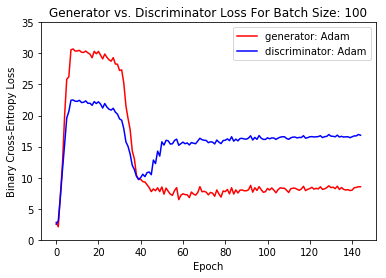

In [207]:
idx = 0
plot_losses(idx)


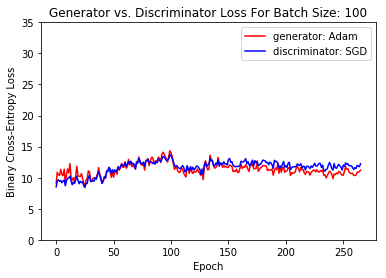

In [208]:
plot_losses(idx+1)

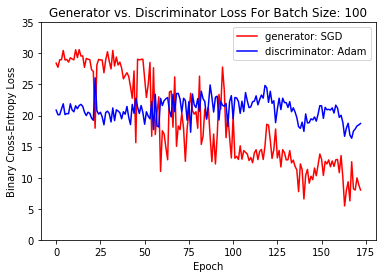

In [209]:
plot_losses(idx+2)

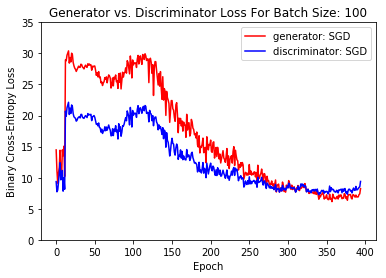

In [210]:
plot_losses(idx+3)

In [98]:
get_params(0)

['batch_size = 100\n',
 'adam_lr = 0.0002\n',
 'adam_beta_1 = 0.5\n',
 'sgd_lr = 0.0002\n',
 'sgd_decay = 1e-6\n',
 'sgd_momentum = 0.9\n',
 'sgd_nesterov = True\n',
 '\n',
 'discriminator: Adam\n',
 'generator: Adam']

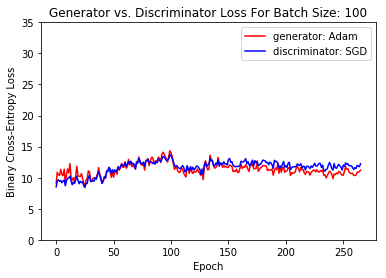

In [211]:
idx = 1
plot_losses(idx)


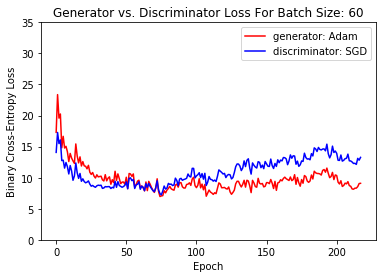

In [212]:
plot_losses(idx+4)

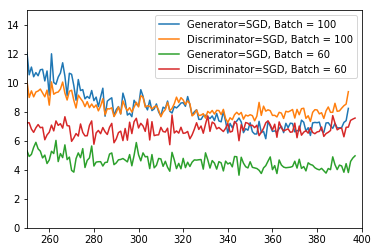

In [120]:
data = load_data(make_histories(), 3)

gen_test = data['test']['generator']
gen_test = np.asarray(gen_test)
# gen_test = gen_test[:, 0]

discrim_test = data['test']['discriminator']
discrim_test = np.asarray(discrim_test)
# discrim_test = discrim_test[:, 0]

mod_data = load_data(make_histories(), 7)
mod_gen_test = mod_data['test']['generator']
mod_gen_test = np.append(gen_test[:240],np.asarray(mod_gen_test), axis=0)
mod_gen_test = mod_gen_test[:,0]

mod_discrim_test = mod_data['test']['discriminator']
mod_discrim_test = np.append(discrim_test[:240],np.asarray(mod_discrim_test), axis=0)
mod_discrim_test = mod_discrim_test[:,0]

gen_test = gen_test[:, 0]
discrim_test = discrim_test[:, 0]

plt.plot(gen_test, label='Generator=SGD, Batch = 100')
plt.plot(discrim_test, label='Discriminator=SGD, Batch = 100')
plt.plot(mod_gen_test, label='Generator=SGD, Batch = 60')
plt.plot(mod_discrim_test, label='Discriminator=SGD, Batch = 60')
plt.ylim(0, 15)
plt.xlim(250, 400)

plt.legend()

In [166]:
def plot_loss_difference(trial):
    data = load_data(make_histories(), trial)

    gen_test = data['test']['generator']
    gen_test = np.asarray(gen_test)
    gen_test = gen_test[:, 0]

    discrim_test = data['test']['discriminator']
    discrim_test = np.asarray(discrim_test)
    discrim_test = discrim_test[:, 0]
    
    x = np.abs(gen_test - discrim_test)
    min_ = np.min(x)
    max_ = np.max(x)

    plt.plot((x-min_)/(max_ - min_), color='red')
#     plt.xlim(240, 400)

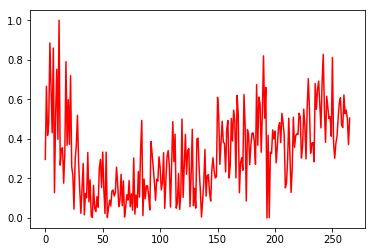

In [167]:
plot_loss_difference(1)

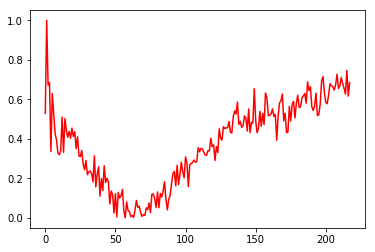

In [168]:
plot_loss_difference(5)